In [3]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML, display
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

import pandas as pd
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.api import OLS
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.metrics import r2_score
from pandas.plotting import scatter_matrix

In [4]:
#from google.colab import drive
#drive.mount('/content/gdrive')

### Read in and basic overview

In [5]:
#path_dataset = 'gdrive/My Drive/CS109BProject/data/Capital_Projects.csv'
path_dataset = '../data/Capital_Projects.csv'

df = pd.read_csv(path_dataset)
print(df.shape)
df.replace('', np.nan, inplace=True)
df = df.dropna()
df = df[df['Budget Forecast'] > 0]
#df = df.dropna(subset=['Budget Forecast'])
df.describe(include='all')
#df.tail(200)

(2259, 16)


,Date Reported As Of,PID,Project Name,Description,Category,Borough,Managing Agency,Client Agency,Current Phase,Design Start,Budget Forecast,Latest Budget Changes,Total Budget Changes,Forecast Completion,Latest Schedule Changes,Total Schedule Changes
count,1056,1056.000000,1056,1056,1056,1056,1056,1056,1056,1056,1.056000e+03,1.056000e+03,1.056000e+03,1056,1056.000000,1056.000000
unique,14,NaN,122,193,16,14,7,21,3,139,NaN,NaN,NaN,553,NaN,NaN
top,09/01/2019 12:00:00 AM,NaN,2nd Avenue Watermain Trunk Construction,Design and construction of a new school,Water Supply,Brooklyn,DDC,DEP,Construction,09/23/2013,NaN,NaN,NaN,09/03/2020,NaN,NaN
freq,122,NaN,14,54,233,276,531,589,555,25,NaN,NaN,NaN,37,NaN,NaN
mean,NaN,402.683712,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.501288e+08,2.999345e+06,2.609627e+07,NaN,80.452652,850.532197
std,NaN,196.351639,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.318676e+08,2.916927e+07,7.860876e+07,NaN,316.080312,789.595380
min,NaN,3.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.297000e+04,-2.155370e+08,-1.743460e+08,NaN,-2832.000000,-1462.000000
25%,NaN,206.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.276200e+07,-1.345000e+05,1.860000e+05,NaN,0.000000,366.000000
50%,NaN,423.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.291750e+07,4.907250e+04,1.462192e+07,NaN,0.000000,816.000000
75%,NaN,545.250000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.166144e+08,2.873803e+06,3.883800e+07,NaN,153.000000,1327.000000


## Regression Model

In [6]:
#### (1) #### CHANGE object to datetime64[ns] for columns with dates, drop NaNs
df['Forecast Completion'] =pd.to_datetime(df['Forecast Completion'], format='%m/%d/%Y', exact=False)
df['Date Reported As Of'] = pd.to_datetime(df['Date Reported As Of'],format='%m/%d/%Y', exact=False)
df['Design Start'] = pd.to_datetime(df['Design Start'], format='%m/%d/%Y', exact=False)
date_reported_min = min(df['Date Reported As Of'])
date_min = min([min(df['Date Reported As Of']), min(df['Design Start']), min(df['Forecast Completion'])])
print(f'Minimum Date: {date_min}')
print(f'Date Reported Minimum: {date_reported_min}')
print(df.shape)
df.head()

Minimum Date: 1996-05-01 00:00:00
Date Reported Minimum: 2014-01-01 00:00:00
(1056, 16)


,Date Reported As Of,PID,Project Name,Description,Category,Borough,Managing Agency,Client Agency,Current Phase,Design Start,Budget Forecast,Latest Budget Changes,Total Budget Changes,Forecast Completion,Latest Schedule Changes,Total Schedule Changes
0,2014-05-01,3,26th Ward Waste Water Treatment Plant Prelimin...,The 26th Ward WWTP is mandated to be upgraded ...,Wastewater Treatment,Brooklyn,DEP,DEP,Design,2013-09-23,1.829810e+08,-1915400.0,-4318643.37,2020-01-14,1.0,270.0
1,2015-02-01,3,26th Ward Waste Water Treatment Plant Prelimin...,The 26th Ward WWTP is mandated to be upgraded ...,Wastewater Treatment,Brooklyn,DEP,DEP,Construction Procurement,2013-09-23,1.687518e+08,-14229191.0,-4318643.37,2020-07-19,187.0,270.0
2,2015-08-01,3,26th Ward Waste Water Treatment Plant Prelimin...,The 26th Ward WWTP is mandated to be upgraded ...,Wastewater Treatment,Brooklyn,DEP,DEP,Construction Procurement,2013-09-23,1.655324e+08,-3219322.0,-4318643.37,2020-08-08,20.0,270.0
3,2016-01-01,3,26th Ward Waste Water Treatment Plant Prelimin...,The 26th Ward WWTP is mandated to be upgraded ...,Wastewater Treatment,Brooklyn,DEP,DEP,Construction,2013-09-23,1.692764e+08,3743944.0,-4318643.37,2020-04-01,-129.0,270.0
4,2016-06-01,3,26th Ward Waste Water Treatment Plant Prelimin...,The 26th Ward WWTP is mandated to be upgraded ...,Wastewater Treatment,Brooklyn,DEP,DEP,Construction,2013-09-23,1.692764e+08,2.0,-4318643.37,2020-04-13,12.0,270.0


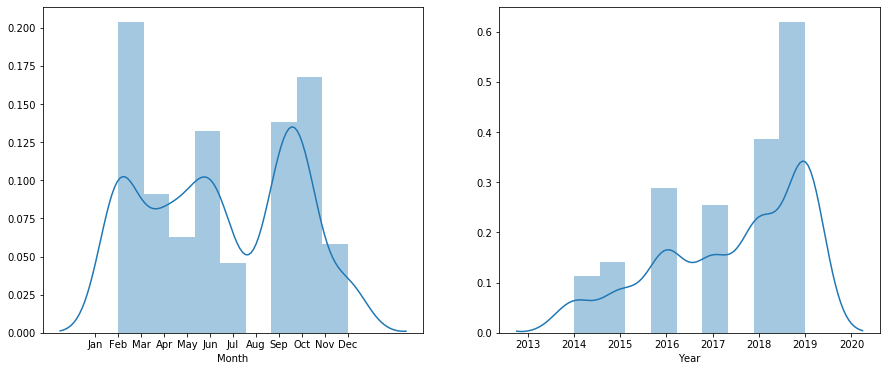

2014

In [7]:
#### (2) #### Extract MONTH and YEAR from Date Reported

df['Month'] = df['Date Reported As Of'].dt.month
df['Year'] = df['Date Reported As Of'].dt.year
month_ticks = {0:'Jan', 1:'Feb',2:'Mar',3:'Apr',4:'May',5:'Jun',6:'Jul',7:'Aug',8:'Sep',9:'Oct',10:'Nov',11:'Dec'}
fig, axes = plt.subplots(1,2, figsize=(15,6))
sns.distplot(df['Month'], ax=axes[0])
axes[0].set_xticks(list(month_ticks.keys()))
axes[0].set_xticklabels(list(month_ticks.values()))
sns.distplot(df['Year'],ax=axes[1])
plt.show()
min(df['Year'])

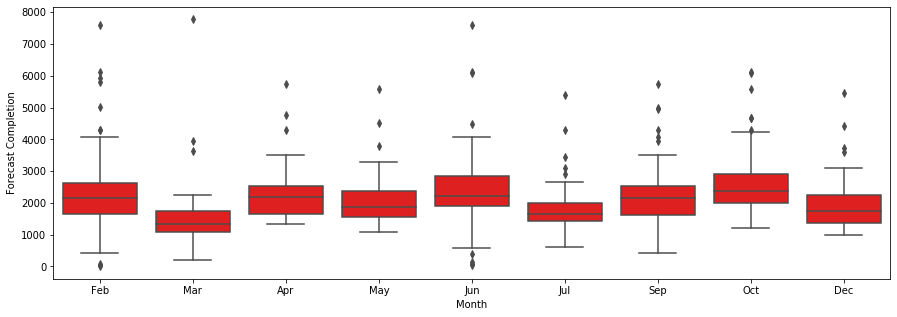

In [8]:
plt_df = df.copy()
plt_df['Forecast Completion'] = pd.to_numeric((plt_df['Forecast Completion'].copy() - min(df['Forecast Completion']))/pd.Timedelta(days=1))
plt.figure(figsize=(15,5))
sns.boxplot(
    data=plt_df,
    x='Month',
    y='Forecast Completion',
    color='red')

plt.xticks([0,1,2,3,4,5,6,7,8],['Feb', 'Mar', 'Apr','May','Jun','Jul','Sep','Oct','Dec'])
plt.show()

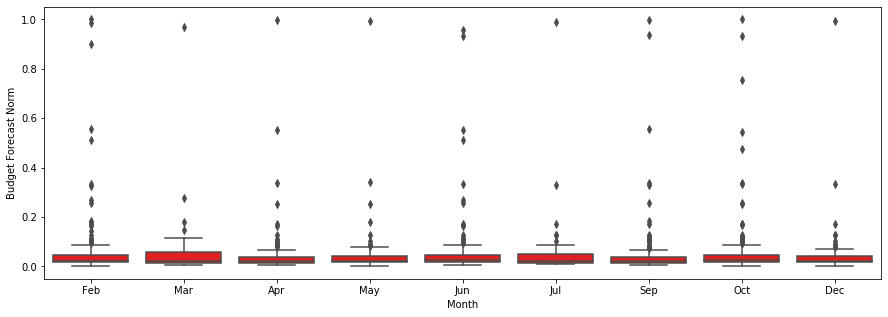

In [9]:
plt_df['Budget Forecast Norm'] = (plt_df['Budget Forecast'] - min(plt_df['Budget Forecast']))/(max(plt_df['Budget Forecast']) - min(plt_df['Budget Forecast']))
plt.figure(figsize=(15,5))
sns.boxplot(
    data=plt_df,
    x='Month',
    y='Budget Forecast Norm',
    color='red')

plt.xticks([0,1,2,3,4,5,6,7,8],['Feb', 'Mar', 'Apr','May','Jun','Jul','Sep','Oct','Dec'])
plt.show()

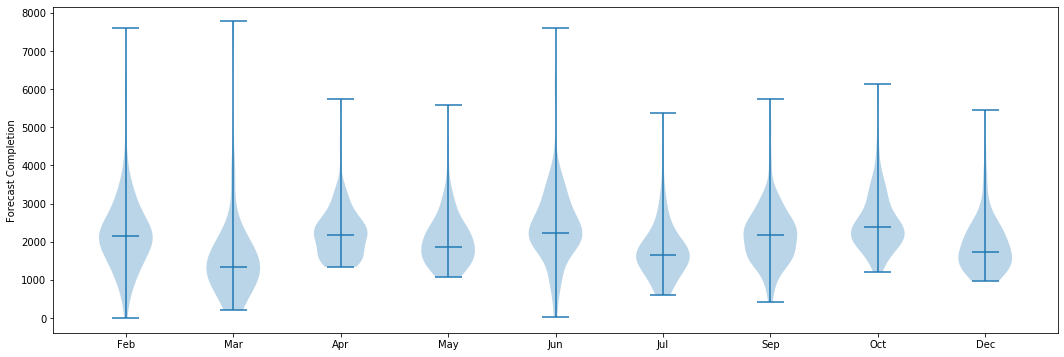

In [10]:
def get_violin_lists(df, x, colname):
  reg_data = []
  col_val = []
  min_val = min(df[x])
  for cur_val, cur_df in df.groupby(colname):
    cur_reg = pd.to_numeric((cur_df[x].copy() - min_val)/pd.Timedelta(days=1)).values.reshape(-1,1)
    reg_data.append(cur_reg)
    col_val.append(cur_val)
  return reg_data, col_val

reg_data, col_val = get_violin_lists(df, 'Forecast Completion', 'Month')
plt.figure(figsize=(18,6))
plt_vals = []
for idx in col_val:
  plt_vals.append(month_ticks[idx])
plt.xticks([0,1,2,3,4,5,6,7,8],plt_vals)
plt.ylabel('Forecast Completion')
plt.violinplot(dataset=reg_data, positions=np.arange(len(reg_data)), showmedians=True, showextrema=True)
plt.show()

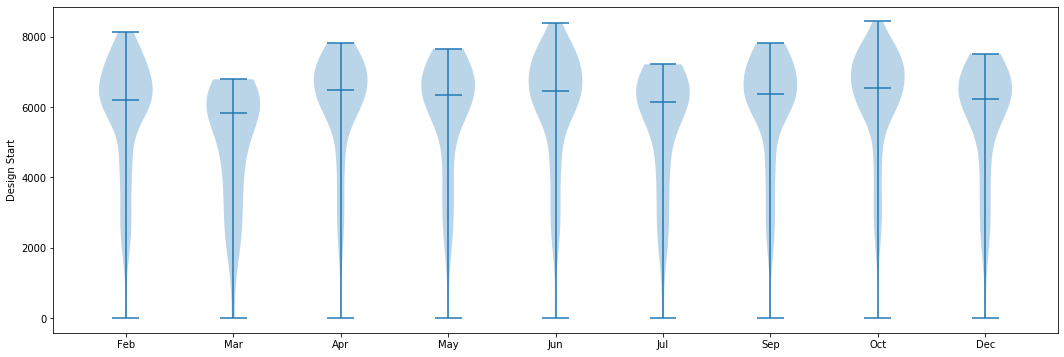

In [11]:
reg_data, col_val = get_violin_lists(df, 'Design Start', 'Month')
plt.figure(figsize=(18,6))
plt_vals = []
for idx in col_val:
  plt_vals.append(month_ticks[idx])
plt.xticks([0,1,2,3,4,5,6,7,8],plt_vals)
plt.violinplot(dataset=reg_data, positions=np.arange(len(reg_data)), showmedians=True, showextrema=True)
plt.ylabel('Design Start')
plt.show()

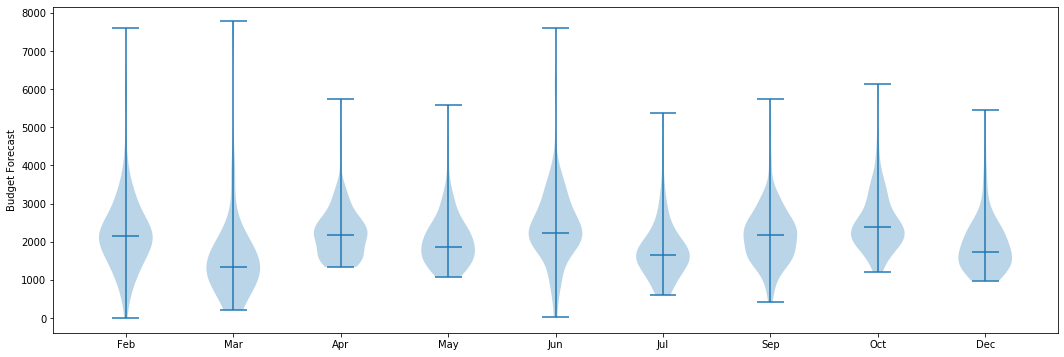

In [12]:
def get_violin_costs(df, x, colname):
  reg_data = []
  col_val = []
  min_val = min(df[x])
  max_val = max(df[x])
  for cur_val, cur_df in df.groupby(colname):
    cur_reg = (cur_df[x]- min_val)/(max_val - min_val)
    reg_data.append(cur_reg)
    col_val.append(cur_val)
  return reg_data, col_val

reg_data, col_val = get_violin_lists(df, 'Forecast Completion', 'Month')
plt.figure(figsize=(18,6))
plt_vals = []
for idx in col_val:
  plt_vals.append(month_ticks[idx])
plt.xticks([0,1,2,3,4,5,6,7,8],plt_vals)
plt.ylabel('Budget Forecast')
plt.violinplot(dataset=reg_data, positions=np.arange(len(reg_data)), showmedians=True, showextrema=True)
plt.show()

In [13]:
#### (3) #### Compute stage of project using Date Reported, Final Forecast Completion
####     #### and Design Start day
### (a) Latest Schedule Changes ===>  Change Normalized to Project Duration of each project
### (b) Forecast Completion Norm ===>  Forecast Normalized to Project Duration of each project
### (c) Project Duration ===> Normalized over all projects (to normalize across big and small projects)

df['Final Date'] = df.groupby(['PID'])['Forecast Completion'].transform('last')
df['Stage'] = (0.9-0.1) * (df['Date Reported As Of'] - df['Design Start']) / (df['Final Date']- df['Design Start']) + 0.1
df['Project Duration'] = df['Final Date'] - df['Design Start']

df['Forecast Completion Norm'] = (df['Forecast Completion'] - df['Design Start'])/df['Project Duration']
df['Schedule Change Norm'] = df['Latest Schedule Changes']/(df['Project Duration']/pd.Timedelta(days=1))
max_project_duration = max(df['Project Duration'])
min_project_duration = min(df['Project Duration'])
df['Project Duration'] = (0.9 - 0.1) * (df['Project Duration'] - min_project_duration) / (max_project_duration - min_project_duration) + 0.1
print(f'Max Project Duration: {max_project_duration} \n Min Project Duration: {min_project_duration} ')
print(df.shape)
df.head()

Max Project Duration: 8644 days 00:00:00 
 Min Project Duration: 1259 days 00:00:00 
(1056, 23)


,Date Reported As Of,PID,Project Name,Description,Category,Borough,Managing Agency,Client Agency,Current Phase,Design Start,...,Forecast Completion,Latest Schedule Changes,Total Schedule Changes,Month,Year,Final Date,Stage,Project Duration,Forecast Completion Norm,Schedule Change Norm
0,2014-05-01,3,26th Ward Waste Water Treatment Plant Prelimin...,The 26th Ward WWTP is mandated to be upgraded ...,Wastewater Treatment,Brooklyn,DEP,DEP,Design,2013-09-23,...,2020-01-14,1.0,270.0,5,2014,2020-10-09,0.168403,0.242343,0.895453,0.000389
1,2015-02-01,3,26th Ward Waste Water Treatment Plant Prelimin...,The 26th Ward WWTP is mandated to be upgraded ...,Wastewater Treatment,Brooklyn,DEP,DEP,Construction Procurement,2013-09-23,...,2020-07-19,187.0,270.0,2,2015,2020-10-09,0.254217,0.242343,0.968131,0.072678
2,2015-08-01,3,26th Ward Waste Water Treatment Plant Prelimin...,The 26th Ward WWTP is mandated to be upgraded ...,Wastewater Treatment,Brooklyn,DEP,DEP,Construction Procurement,2013-09-23,...,2020-08-08,20.0,270.0,8,2015,2020-10-09,0.310494,0.242343,0.975904,0.007773
3,2016-01-01,3,26th Ward Waste Water Treatment Plant Prelimin...,The 26th Ward WWTP is mandated to be upgraded ...,Wastewater Treatment,Brooklyn,DEP,DEP,Construction,2013-09-23,...,2020-04-01,-129.0,270.0,1,2016,2020-10-09,0.358065,0.242343,0.925768,-0.050136
4,2016-06-01,3,26th Ward Waste Water Treatment Plant Prelimin...,The 26th Ward WWTP is mandated to be upgraded ...,Wastewater Treatment,Brooklyn,DEP,DEP,Construction,2013-09-23,...,2020-04-13,12.0,270.0,6,2016,2020-10-09,0.405325,0.242343,0.930431,0.004664


In [14]:
#### (3) #### Compute stage of project using Date Reported, Final Forecast Completion
####     #### and Design Start day
### (a) Latest Budget Changes ===>  Budget Change Normalized to Final Budget of each project
### (b) Budget Forecast Norm ===> Budget Forecast Normalized to Final Budget of each project
### (c) Final Budget  ===> Normalized over all projects (to normalize across big and small projects)

df['Final Budget'] = df.groupby(['PID'])['Budget Forecast'].transform('last')
df['Budget Forecast Norm'] = df['Budget Forecast'] / df['Final Budget']
df['Budget Change Norm'] = df['Latest Budget Changes'] / df['Final Budget']
max_budget_final = max(df['Final Budget'])
min_budget_final = min(df['Final Budget'])
df['Final Budget'] = (0.9-0.1)*(df['Final Budget'] - min_budget_final)/(max_budget_final - min_budget_final) + 0.1
print(f'Max Budget: {max_budget_final} \n Min Budget: {min_budget_final}')
df.dtypes

Max Budget: 2449621616.0 
 Min Budget: 17113529.0


Date Reported As Of         datetime64[ns]
PID                                  int64
Project Name                        object
Description                         object
Category                            object
Borough                             object
Managing Agency                     object
Client Agency                       object
Current Phase                       object
Design Start                datetime64[ns]
Budget Forecast                    float64
Latest Budget Changes              float64
Total Budget Changes               float64
Forecast Completion         datetime64[ns]
Latest Schedule Changes            float64
Total Schedule Changes             float64
Month                                int64
Year                                 int64
Final Date                  datetime64[ns]
Stage                              float64
Project Duration                   float64
Forecast Completion Norm           float64
Schedule Change Norm               float64
Final Budge

In [15]:
####  (4)  #### Handle Categorical Columns using dummy variables
categorical_columns = ['Category', 'Borough', 'Current Phase'] # not including Agencies nor Decription
nyc_df = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

#### (5) #### Drop redundant or useless columns, and drop NaNs
drop_columns = ['Date Reported As Of', 'PID', 'Project Name', 'Description','Managing Agency', 
                'Client Agency', 'Design Start', 'Budget Forecast', 'Latest Budget Changes', 
                'Latest Schedule Changes', 'Total Schedule Changes', 'Total Budget Changes', 
                'Forecast Completion', 'Year', 'Final Date']
nyc_df = nyc_df.drop(drop_columns, axis=1)
nyc_df.describe(include='all')


,Month,Stage,Project Duration,Forecast Completion Norm,Schedule Change Norm,Final Budget,Budget Forecast Norm,Budget Change Norm,Category_Bridges,"Category_Bridges, Streets and Roadways",...,Borough_Marlboro,Borough_New York,Borough_Olive,Borough_Port Jervis,Borough_Queens,Borough_Staten Island,Borough_Upstate,Borough_Valhalla,Current Phase_Construction Procurement,Current Phase_Design
count,1056.000000,1056.000000,1056.000000,1056.000000,1056.000000,1056.000000,1056.000000,1056.000000,1056.000000,1056.000000,...,1056.000000,1056.000000,1056.000000,1056.000000,1056.000000,1056.000000,1056.000000,1056.000000,1056.000000,1056.000000
mean,5.503788,0.521296,0.334320,0.895093,0.023500,0.146236,0.932674,0.017512,0.007576,0.013258,...,0.013258,0.012311,0.007576,0.010417,0.207386,0.099432,0.026515,0.010417,0.127841,0.346591
std,3.212827,0.199947,0.171517,0.186865,0.103966,0.109646,0.293000,0.214621,0.086750,0.114430,...,0.114430,0.110320,0.086750,0.101577,0.405627,0.299383,0.160738,0.101577,0.334071,0.476110
min,1.000000,0.073826,0.100000,0.288584,-1.292560,0.100000,0.000891,-1.753631,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,0.365071,0.221544,0.783855,0.000000,0.111173,0.869862,-0.001314,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,5.000000,0.534814,0.267150,0.922205,0.000000,0.117950,0.978560,0.000330,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.000000,0.683808,0.419567,1.000000,0.043662,0.134794,1.000000,0.029299,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,11.000000,0.933982,0.900000,1.929032,0.679179,0.900000,2.888803,1.556554,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


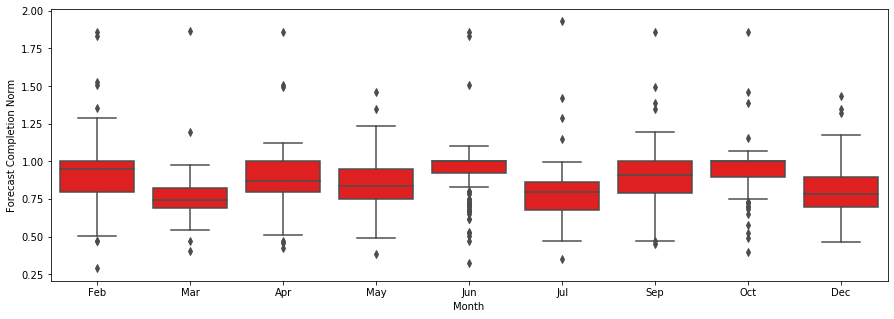

1.929032258064516

In [16]:
plt.figure(figsize=(15,5))
sns.boxplot(
    data=nyc_df,
    x='Month',
    y='Forecast Completion Norm',
    color='red')

plt.xticks([0,1,2,3,4,5,6,7,8],['Feb', 'Mar', 'Apr','May','Jun','Jul','Sep','Oct','Dec'])
plt.show()
max(df['Forecast Completion Norm'])

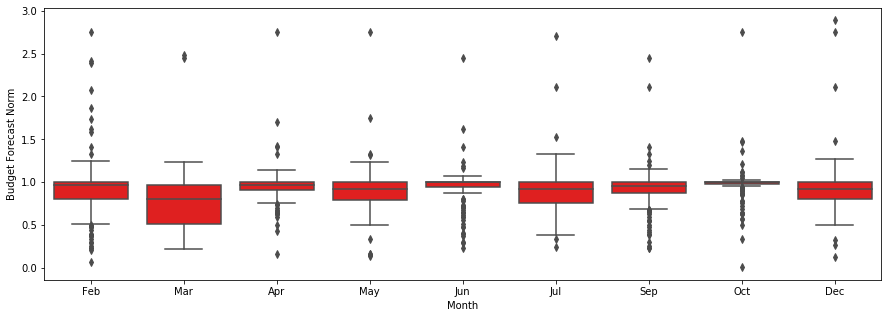

In [17]:
plt.figure(figsize=(15,5))
sns.boxplot(
    data=nyc_df,
    x='Month',
    y='Budget Forecast Norm',
    color='red')

plt.xticks([0,1,2,3,4,5,6,7,8],['Feb', 'Mar', 'Apr','May','Jun','Jul','Sep','Oct','Dec'])
plt.show()

In [18]:
nyc_df = nyc_df.dropna()
nyc_train, nyc_test = train_test_split(nyc_df, test_size=.2, random_state=90)

In [19]:
print(nyc_train.shape)
nyc_train.head()

(844, 38)


,Month,Stage,Project Duration,Forecast Completion Norm,Schedule Change Norm,Final Budget,Budget Forecast Norm,Budget Change Norm,Category_Bridges,"Category_Bridges, Streets and Roadways",...,Borough_Marlboro,Borough_New York,Borough_Olive,Borough_Port Jervis,Borough_Queens,Borough_Staten Island,Borough_Upstate,Borough_Valhalla,Current Phase_Construction Procurement,Current Phase_Design
863,8,0.480927,0.290765,0.699338,0.000000,0.105472,0.806263,-0.017451,0,0,...,0,0,0,0,0,0,0,0,0,0
1441,3,0.150352,0.240718,0.866693,-0.003909,0.240610,0.979479,0.257751,0,0,...,0,0,0,0,0,0,0,0,0,1
1598,9,0.752774,0.283832,1.000000,0.081529,0.118686,1.000000,0.001407,0,0,...,0,0,0,0,0,0,0,0,0,0
540,9,0.727335,0.624631,0.880203,0.000000,0.132590,0.874448,0.004406,0,0,...,0,0,0,0,0,0,0,0,0,0
629,3,0.527229,0.364645,0.797677,0.031334,0.116988,0.977989,0.019394,0,0,...,0,0,0,0,0,1,0,0,0,1


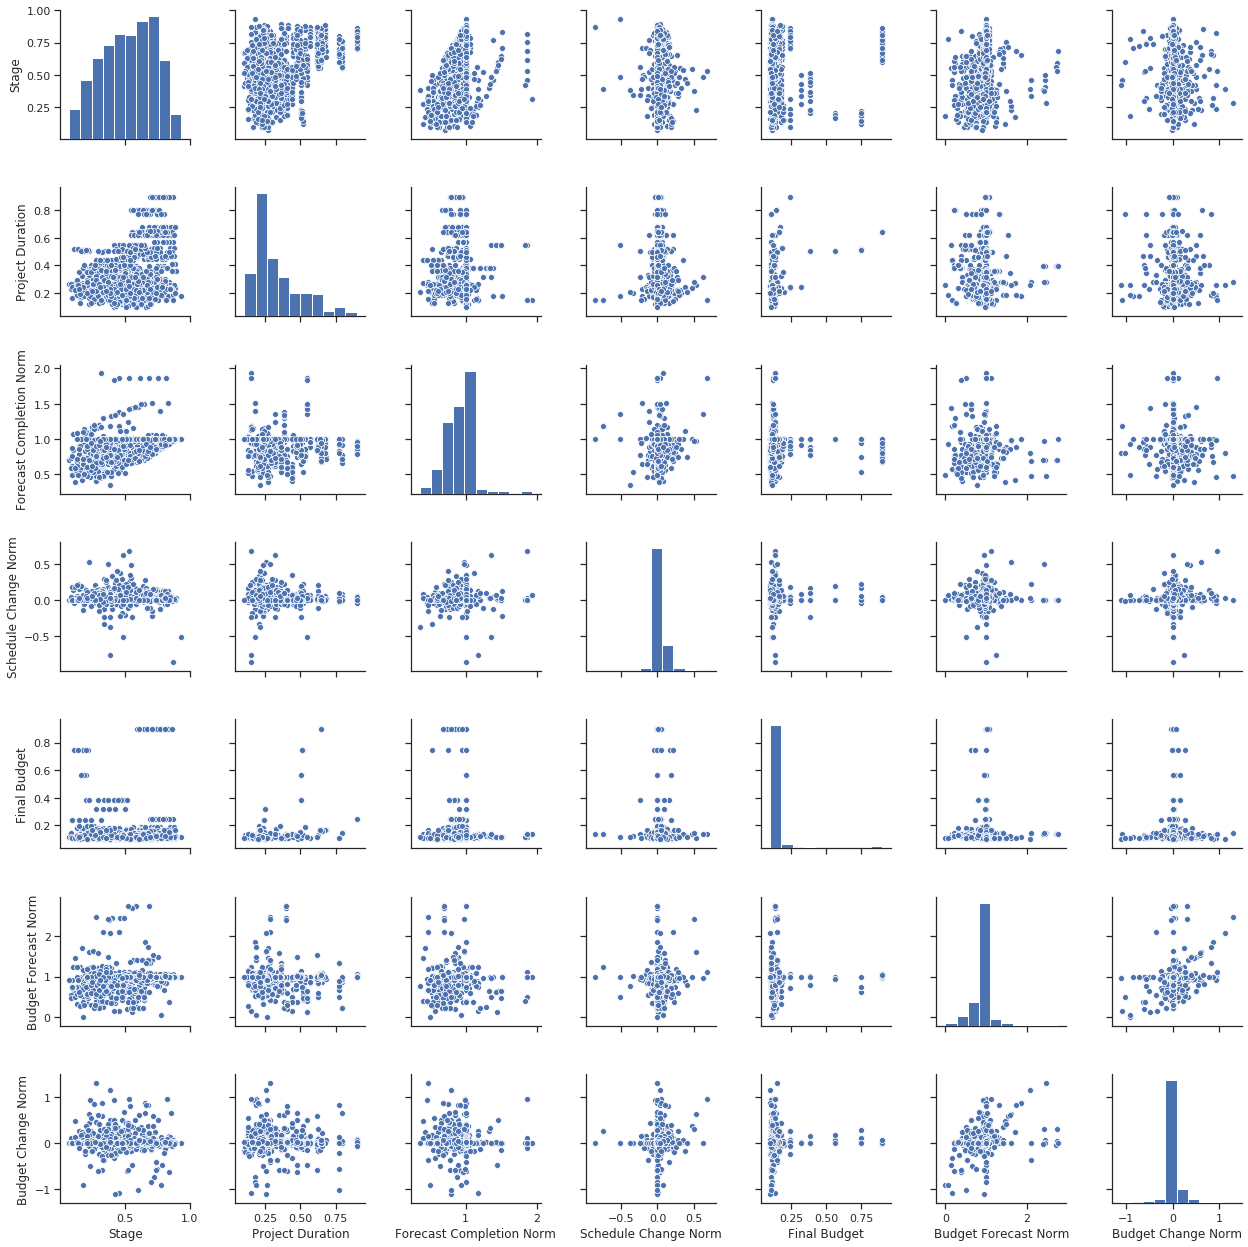

In [20]:
qual_columns = ['Stage', 'Project Duration', 'Forecast Completion Norm', 'Schedule Change Norm',
                'Final Budget', 'Budget Forecast Norm', 'Budget Change Norm']	
#scatter_matrix(nyc_train[qual_columns].sample(frac=0.4, axis=0),alpha=0.5, figsize=(25,20));
import seaborn as sns
sns.set(style="ticks")
sns.pairplot(nyc_train[qual_columns])

In [21]:
nyc_train[qual_columns].corr()

,Stage,Project Duration,Forecast Completion Norm,Schedule Change Norm,Final Budget,Budget Forecast Norm,Budget Change Norm
Stage,1.000000,0.339013,0.375348,-0.093494,0.008426,0.167482,-0.068051
Project Duration,0.339013,1.000000,-0.047517,-0.020635,0.339148,-0.072403,-0.034843
Forecast Completion Norm,0.375348,-0.047517,1.000000,0.064949,-0.034089,0.045687,-0.032333
Schedule Change Norm,-0.093494,-0.020635,0.064949,1.000000,0.009647,0.019528,0.093802
Final Budget,0.008426,0.339148,-0.034089,0.009647,1.000000,0.035318,0.000610
Budget Forecast Norm,0.167482,-0.072403,0.045687,0.019528,0.035318,1.000000,0.284504
Budget Change Norm,-0.068051,-0.034843,-0.032333,0.093802,0.000610,0.284504,1.000000


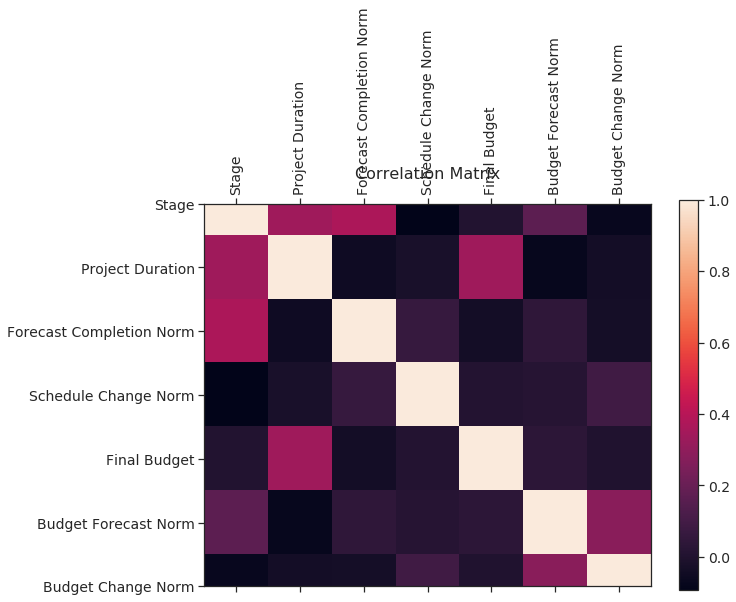

In [22]:
f = plt.figure(figsize=(10, 7))
plt.matshow(nyc_train[qual_columns].corr(), fignum=f.number)
plt.xticks(range(len(qual_columns)), qual_columns, fontsize=14, rotation=90)
plt.yticks(range(len(qual_columns)), qual_columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

In [23]:
# Budget change
y_train = nyc_train['Budget Change Norm']
X_train = nyc_train.drop(['Budget Change Norm'], axis=1)
fitted_model = LinearRegression().fit(X_train, y_train)
fitted_model.score(X_train, y_train)

# Normalization or Standardization
# DateTime => numeric - (- 2013) 
# QQ plot (normal plot)

0.1470594190721578

In [24]:
X_train = sm.add_constant(X_train)
results = OLS(y_train, X_train).fit()
results.summary()

/usr/share/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     Budget Change Norm   R-squared:                       0.147
Model:                            OLS   Adj. R-squared:                  0.109
Method:                 Least Squares   F-statistic:                     3.865
Date:                Wed, 06 May 2020   Prob (F-statistic):           1.01e-12
Time:                        13:10:13   Log-Likelihood:                 244.26
No. Observations:                 844   AIC:                            -414.5
Df Residuals:                     807   BIC:                            -239.2
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
=========================================================================================================================
                                                            coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------
const                                                    -0.1059      0.070     -1.516      0.130      -0.243       0.031
Month                                                    -0.0008      0.002     -0.389      0.697      -0.005       0.003
Stage                                                    -0.0458      0.062     -0.740      0.459      -0.167       0.076
Project Duration                                         -0.0856      0.060     -1.416      0.157      -0.204       0.033
Forecast Completion Norm                                 -0.0372      0.042     -0.885      0.376      -0.120       0.045
Schedule Change Norm                                      0.1609      0.071      2.252      0.025       0.021       0.301
Final Budget                                              0.0244      0.072      0.338      0.735      -0.117       0.166
Budget Forecast Norm                                      0.2653      0.025     10.666      0.000       0.217       0.314
Category_Bridges                                         -0.0847      0.044     -1.903      0.057      -0.172       0.003
Category_Bridges, Streets and Roadways                    0.0733      0.073      1.009      0.313      -0.069       0.216
Category_Ferries                                          0.0749      0.103      0.728      0.467      -0.127       0.277
Category_Health and Hospitals                            -0.0558      0.063     -0.881      0.379      -0.180       0.069
Category_Industrial Development                          -0.0489      0.053     -0.915      0.361      -0.154       0.056
Category_Industrial Development, Streets and Roadways    -0.0637      0.100     -0.639      0.523      -0.259       0.132
Category_Other Government Facilities                      0.0290      0.063      0.461      0.645      -0.095       0.153
Category_Parks                                            0.0331      0.064      0.515      0.606      -0.093       0.159
Category_Public Safety and Criminal Justice              -0.0500      0.059     -0.850      0.396      -0.166       0.065
Category_Sanitation                                      -0.0226      0.059     -0.385      0.700      -0.138       0.093
Category_Schools                                         -0.1087      0.056     -1.928      0.054      -0.219       0.002
Category_Sewers                                          -0.0535      0.050     -1.064      0.288      -0.152       0.045
Category_Streets and Roadways                             0.0266      0.050      0.527      0.599      -0.073       0.126
Category_Wastewater Treatment                            -0.0498      0.049     -1.009      0.313      -0.147       0.047
Category_Water Supply            

In [25]:
# Multi-collinearity
X_train_save = X_train.copy()
from statsmodels.stats.outliers_influence import variance_inflation_factor
pd.Series([variance_inflation_factor(X_train.values, i) 
               for i in range(X_train.shape[1])], 
               index=X_train.columns)

/usr/share/anaconda3/lib/python3.7/site-packages/statsmodels/stats/outliers_influence.py:185: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


const                                                    119.972388
Month                                                      1.027519
Stage                                                      3.793537
Project Duration                                           2.652976
Forecast Completion Norm                                   1.549285
Schedule Change Norm                                       1.075649
Final Budget                                               1.706534
Budget Forecast Norm                                       1.263262
Category_Bridges                                                inf
Category_Bridges, Streets and Roadways                     1.670172
Category_Ferries                                           1.535644
Category_Health and Hospitals                              2.057477
Category_Industrial Development                            4.563753
Category_Industrial Development, Streets and Roadways      1.438089
Category_Other Government Facilities            

In [26]:
# Remove multi-collinearity
# Transforms

X_train = X_train_save.copy()
drop_mc_columns = ['Borough_Olive', 'Category_Bridges']
X_train = X_train.drop(drop_mc_columns, axis=1)
X_train['Final Budget'] = np.log(X_train['Final Budget'])
X_train['Stage'] = np.log(X_train['Stage'])
X_train['Month'] = np.log(X_train['Month'])
results = OLS(np.exp(y_train), X_train).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     Budget Change Norm   R-squared:                       0.166
Model:                            OLS   Adj. R-squared:                  0.130
Method:                 Least Squares   F-statistic:                     4.603
Date:                Wed, 06 May 2020   Prob (F-statistic):           3.68e-16
Time:                        13:10:14   Log-Likelihood:                 51.979
No. Observations:                 844   AIC:                            -31.96
Df Residuals:                     808   BIC:                             138.6
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
=========================================================================================================================
                                                            coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------
const                                                     0.8491      0.122      6.963      0.000       0.610       1.088
Month                                                    -0.0070      0.010     -0.713      0.476      -0.026       0.012
Stage                                                    -0.0010      0.031     -0.032      0.975      -0.061       0.059
Project Duration                                         -0.1685      0.079     -2.138      0.033      -0.323      -0.014
Forecast Completion Norm                                 -0.0915      0.051     -1.783      0.075      -0.192       0.009
Schedule Change Norm                                      0.2394      0.090      2.674      0.008       0.064       0.415
Final Budget                                              0.0210      0.032      0.653      0.514      -0.042       0.084
Budget Forecast Norm                                      0.3430      0.031     11.017      0.000       0.282       0.404
Category_Bridges, Streets and Roadways                    0.1357      0.087      1.561      0.119      -0.035       0.306
Category_Ferries                                          0.1349      0.126      1.074      0.283      -0.112       0.381
Category_Health and Hospitals                            -0.0136      0.074     -0.183      0.855      -0.160       0.132
Category_Industrial Development                           0.0253      0.058      0.434      0.664      -0.089       0.140
Category_Industrial Development, Streets and Roadways    -0.0048      0.119     -0.040      0.968      -0.239       0.229
Category_Other Government Facilities                      0.0829      0.074      1.127      0.260      -0.061       0.227
Category_Parks                                            0.1056      0.075      1.402      0.161      -0.042       0.253
Category_Public Safety and Criminal Justice               0.0228      0.067      0.342      0.732      -0.108       0.154
Category_Sanitation                                       0.0257      0.067      0.384      0.701      -0.105       0.157
Category_Schools                                         -0.0628      0.063     -0.998      0.318      -0.186       0.061
Category_Sewers                                           0.0160      0.055      0.293      0.770      -0.091       0.123
Category_Streets and Roadways                             0.1426      0.055      2.587      0.010       0.034       0.251
Category_Wastewater Treatment                             0.0006      0.053      0.011      0.992      -0.104       0.105
Category_Water Supply                                    -0.0085      0.052     -0.162      0.871      -0.111       0.094
Borough_Brooklyn                 

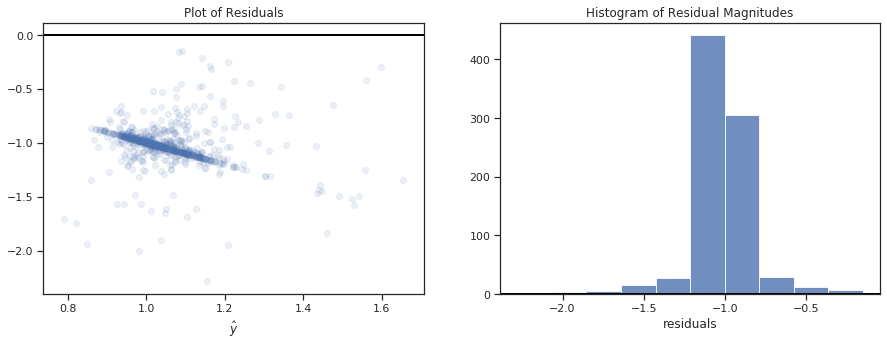

In [27]:
# Residual Plots
y_hat_train = results.predict()
residuals = y_train - y_hat_train
fig, axes = plt.subplots(1,2,figsize=(15,5))
axes[0].set_title('Plot of Residuals')
axes[0].scatter(y_hat_train, residuals, alpha=0.1)
axes[0].axhline(0, c='black', lw=2)
axes[0].set_xlabel(r'$\hat{y}$')
axes[1].set_title('Histogram of Residual Magnitudes')
axes[1].hist(residuals, alpha=0.8)
axes[1].axhline(0, c='black', lw=2)
axes[1].set_xlabel(r'residuals')
plt.show()


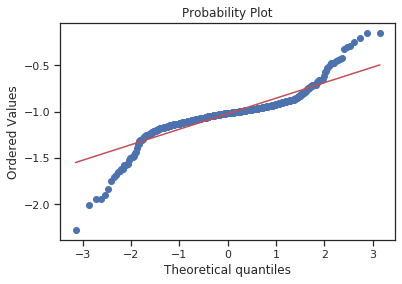

In [28]:
import pylab 
import scipy.stats as stats

stats.probplot(residuals, dist="norm", plot=pylab)
pylab.show()

## GAM Models

In [39]:
from pygam import LinearGAM, s, f
#from sklearn.metrics import r2_score
from sklearn.model_selection import KFold


In [49]:
smoothings = np.logspace(-3, 6, 9)
cv = 10

kf = KFold(n_splits=cv, random_state=42, shuffle=True)
scores = np.zeros((cv,len(smoothings)))

print(smoothings,'\n')
print(scores.shape, '\n')
print(nyc_train.shape)

[1.00000000e-03 1.33352143e-02 1.77827941e-01 2.37137371e+00
 3.16227766e+01 4.21696503e+02 5.62341325e+03 7.49894209e+04
 1.00000000e+06] 

(10, 9) 

(844, 38)


In [46]:
for i, (train_index, test_index) in enumerate(kf.split(nyc_train)):
    train_df = nyc_train.iloc[train_index,:]
    test_df = nyc_train.iloc[test_index,:]
    
    for j, smoothing in enumerate(smoothings):
        cur_model = LinearGAM(s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8) + f(9) + f(10) + f(11) + f(12) + f(13) + f(14) + f(15) + f(16) + f(17) + f(18) + f(19) + f(20) + f(21) + f(22) + f(23) + f(24) + f(25) + f(26) + f(27) + f(28) + f(29) + f(30) + f(31) + f(32) + f(33) + f(34) + f(35) + f(36) + f(37) + f(38), lam = smoothing).fit(nyc_train, tra)
        scores[i,j] = r2_score(test_df.price, cur_model.predict(test_df))
                              
best_lambda = smoothings[np.argmax(np.mean(scores, axis = 0))]
best_lambda

AttributeError: 'DataFrame' object has no attribute 'price'

In [48]:
X_train.shape, nyc_train.shape

((844, 36), (844, 38))

In [42]:
nyc_train.dtypes

Month                                                      int64
Stage                                                    float64
Project Duration                                         float64
Forecast Completion Norm                                 float64
Schedule Change Norm                                     float64
Final Budget                                             float64
Budget Forecast Norm                                     float64
Budget Change Norm                                       float64
Category_Bridges                                           uint8
Category_Bridges, Streets and Roadways                     uint8
Category_Ferries                                           uint8
Category_Health and Hospitals                              uint8
Category_Industrial Development                            uint8
Category_Industrial Development, Streets and Roadways      uint8
Category_Other Government Facilities                       uint8
Category_Parks           

In [44]:
nyc_train.head()

,Month,Stage,Project Duration,Forecast Completion Norm,Schedule Change Norm,Final Budget,Budget Forecast Norm,Budget Change Norm,Category_Bridges,"Category_Bridges, Streets and Roadways",...,Borough_Marlboro,Borough_New York,Borough_Olive,Borough_Port Jervis,Borough_Queens,Borough_Staten Island,Borough_Upstate,Borough_Valhalla,Current Phase_Construction Procurement,Current Phase_Design
863,8,0.480927,0.290765,0.699338,0.000000,0.105472,0.806263,-0.017451,0,0,...,0,0,0,0,0,0,0,0,0,0
1441,3,0.150352,0.240718,0.866693,-0.003909,0.240610,0.979479,0.257751,0,0,...,0,0,0,0,0,0,0,0,0,1
1598,9,0.752774,0.283832,1.000000,0.081529,0.118686,1.000000,0.001407,0,0,...,0,0,0,0,0,0,0,0,0,0
540,9,0.727335,0.624631,0.880203,0.000000,0.132590,0.874448,0.004406,0,0,...,0,0,0,0,0,0,0,0,0,0
629,3,0.527229,0.364645,0.797677,0.031334,0.116988,0.977989,0.019394,0,0,...,0,0,0,0,0,1,0,0,0,1
